# K-Nearest Neighbor

In this notebook, we will include all the codes that are needed to make a real classifier algorithm.

### GUI stuff
The following codes are very very important and needed to be processed individually before running an algorithm.

In [1]:
%gui qt

In [2]:
%gui
%gui wx

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This will make matplotlib figures show inline.
%matplotlib inline  

# This will make the notebook reload external python automatically.
%load_ext autoreload
%autoreload 2

The following is for the parameters for plotting:

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Input 
The following will be used for getting input from the CIFAR-10 dataset.

In [5]:
import cPickle as pickle
import numpy as np
import os

def load_CIFAR_batch(filename):
    """ load a single batch of CIFAR
    """
    with open(filename, 'rb') as f:
        # Note that CIFAR-10 dataset is produced with cPickle.
        datadict = pickle.load(f) 
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype('float')
        Y = np.array(Y)
        return X,Y

def load_CIFAR10(ROOT):
    """ load all of CIFAR dataset
    """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X,Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

** This is the setting for the raw CIFAR-10 directory. **

In [6]:
cifar10_dir = 'cifar-10-batches-py'

Now, we will get the data.

In [7]:
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

You can change the following code to check the shape of the dataset: 

### Visualization
For this section, we will write code to visualize some random examples from the dataset.

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        # enumerate by column
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### L2 distance classifier 
In this section, we will use L2 distance as a classifier to classify the input.

In [ ]:
# We need to subsample the data for more efficient coude execution
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Then, we need to reshape the image data into rows.
X_train = np.reshape(X_train,(X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.


In [10]:
import numpy as np

class KNearestNeighbor:
    """ a kNN classsifier with L2 distance
    """
    
    def __init__(self):
        pass
    
    def train(self, X, y):
        """ Train the classifier. For k-nearest neighbors, 
            this is just memorizing the training data.
            
            Input:
            X - A num_train x dimension array where each row 
                represents a single training point.
            y - A vector of length num_train, where y[i] is the 
                label for X[i, :]
        """
        self.X_train = X
        self.y_train = y
        
    def predict(self, X, k=1, num_loops=0):
        """ Predict labels for test data using the classifier.
        
            Input:
            X - A num_test x dimension array where each row represents
                a single test point.
            k - The number of nearest neighbors that vote for predicte
                label.
            num_loops - Determines which method to use to compute distances
                        between training points and test points.
        
            Output:
            y - A vector of length num_test, where y[i] represents the 
                predicted label for the test point X[i, :].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists,k=k)

    def compute_distances_two_loops(self, X):
        """ Compute the distance between each test point in X and each 
            training point in self.X_train using a nested loop over both 
            the training data and the test data.
            
            Input:
            X - A num_test x dimension array where each row is a test point.
            
            Output:
            dists - A num_test x num_train array where dists[i, j] gives
                    the distance between the ith test point and the jth 
                    training point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test,num_train))
        for i in xrange(num_test):
            for j in xrange(num_train):
                dists[i,j] = np.sqrt(np.sum(np.square(X[i,:] - self.X_train[j,:])))
        return dists
    
    def compute_distances_one_loop(self,X):
        """ Same as compute_disances_two_loops; however, we will use just one 
            loop instead.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test,num_train))
        for i in xrange(num_test):
            dists[i,:] = np.sqrt(np.sum(np.square(X[i,:] - self.X_train),axis=1))
        return dists
    
    def compute_distances_no_loops(self,X):
        """ Same as compute_disances_two_loops; however, we will use just one 
            loop instead.
        """
        X2 = np.dot(X**2,np.ones(self.X_train.shape).T)
        XY = np.dot(X,self.X_train.T)
        Y2 = np.dot(np.ones(X.shape),self.X_train.T**2)
        dists = X2 - 2*XY + Y2
        del X2,XY,Y2
        return dists
    
    def predict_labels(self, dists, k=1):
        """ Given a matrix of distances between test points and training 
            points, predict a label for each test point.
            
            Input:
            dists - A num_test x num_train array where dists[i, j] gives
                    the distance between the ith test point and the jth 
                    training point.
            Output:
            y - A vector of length num_test where y[i] represents the 
                predicted label for the ith test point.
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in xrange(num_test):
            # closest_y is a list of length k storing the labels for
            # the k nearest neighbors to the ith test points
            order = np.argsort(np.array(dists[i,:]))[:k]
            closest_y = [self.y_train[y] for y in order]
            
            hashmap = {}
            for y in closest_y:
                if y in hashmap.keys():
                    hashmap[y] += 1
                else:
                    hashmap[y] = 1
            maxval = -1
            maxidx = 1e9
            for y in closest_y:
                if hashmap[y] > maxval:
                    maxval = hashmap[y]
                    maxidx = y
                elif hashmap[y] == maxval and y < maxidx:
                    maxidx = y
                    
            y_pred[i] = maxidx
            del hashmap, order, closest_y
        return y_pred

In [ ]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [ ]:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

In [ ]:
# Visualize the distance matrix: each row is a single test example
# and its distances to trianing examples
plt.imshow(dists, interpolation='none')

**Inline Question #1:** Notice the structured patterns in the distance matrix. 

- What is the cause behind the distinctly visible rows? 
- What causes the columns?

**Answer**: 
- The white row tends to visually imply that single test example is away from others so that it can form its own cluster.
- The white column visually shows that paramater is significantly important in distinguishing the examples.

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

In [ ]:
# Now we will implement the fully vectorized version inside compute_distance_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check if the distance matrix agrees with the one already computed
# difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

In [ ]:
# Now, let's see how fast the vectorizations are.
def time_function(f, *args):
    """ Call a function f with args and return the time (in seconds)
        that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [14]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

# We'll split up the input into num_folds partition to do cross-validation.
X_train_folds = np.array(np.array_split(X_train,num_folds))
y_train_folds = np.array(np.array_split(y_train,num_folds))

print X_train_folds.shape, y_train_folds.shape

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

for k in k_choices:
    accuracy = []
    for i in xrange(num_folds):
        classifier = KNearestNeighbor()
        
#         print "shape = " + str(X_train_folds[1].shape)
        if i == 0:
            X_train_folds_tmp = X_train_folds[1]
            y_train_folds_tmp = y_train_folds[1]
        else:
            X_train_folds_tmp = X_train_folds[0]
            y_train_folds_tmp = y_train_folds[0]
        
        for j in xrange(1,num_folds):
            if i != j:
                X_train_folds_tmp = np.concatenate((X_train_folds_tmp,X_train_folds[j]))
                y_train_folds_tmp = np.concatenate((y_train_folds_tmp,y_train_folds[j]))
#         print X_train_folds_tmp.shape, y_train_folds_tmp.shape
        classifier.train(X_train_folds_tmp, y_train_folds_tmp)
        
        dists = classifier.compute_distances_no_loops(X_train_folds[i])
        y_test_pred = classifier.predict_labels(dists, k)
        
        num_correct = np.sum(y_test_pred == y_train_folds[i])
        acc = float(num_correct) / float(len(y_train_folds[i]))
        accuracy.append(acc)
    k_to_accuracies[k] = accuracy

# Check the accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

(5, 10000, 3072) (5, 10000)
k = 1, accuracy = 0.335800
k = 1, accuracy = 0.336100
k = 1, accuracy = 0.346900
k = 1, accuracy = 0.334600
k = 1, accuracy = 0.338300
k = 3, accuracy = 0.324400
k = 3, accuracy = 0.326100
k = 3, accuracy = 0.328000
k = 3, accuracy = 0.325200
k = 3, accuracy = 0.317800
k = 5, accuracy = 0.325500
k = 5, accuracy = 0.329700
k = 5, accuracy = 0.333600
k = 5, accuracy = 0.334000
k = 5, accuracy = 0.328300
k = 8, accuracy = 0.334000
k = 8, accuracy = 0.328300
k = 8, accuracy = 0.334100
k = 8, accuracy = 0.330700
k = 8, accuracy = 0.323000
k = 10, accuracy = 0.335800
k = 10, accuracy = 0.325200
k = 10, accuracy = 0.333000
k = 10, accuracy = 0.333200
k = 10, accuracy = 0.324300
k = 12, accuracy = 0.335200
k = 12, accuracy = 0.323600
k = 12, accuracy = 0.328100
k = 12, accuracy = 0.329400
k = 12, accuracy = 0.323900
k = 15, accuracy = 0.335200
k = 15, accuracy = 0.323500
k = 15, accuracy = 0.328400
k = 15, accuracy = 0.327300
k = 15, accuracy = 0.321500
k = 20, accu

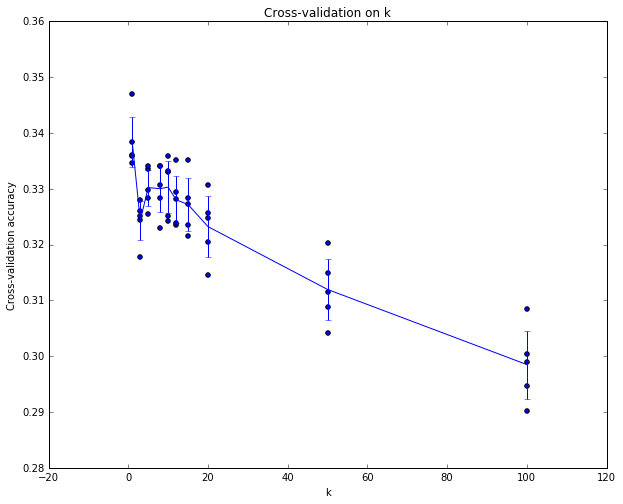

In [15]:
# plot the raw observations
for k in k_choices:
    accuracy = k_to_accuracies[k]
    plt.scatter([k] * len(accuracy), accuracy)

# plot the trend line
accuracy_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracy_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracy_mean, yerr=accuracy_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [16]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data.
best_k = 100

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train = np.reshape(X_train,(X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
num_test = float(len(y_test_pred))
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 3118 / 10000 correct => accuracy: 0.311800


In [ ]:
print y_test